# Initial Data Exploration

In [1]:
import pandas as pd
import geopandas
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import numpy as np
import warnings
import math
import re

warnings.filterwarnings("ignore")


%load_ext autoreload
%autoreload 2

%run ../src/utils.py

In [2]:
train = pd.read_csv('../data/raw/data_train.zip', index_col='Unnamed: 0')
train.shape

(814262, 11)

In [3]:
test = pd.read_csv('../data/raw/data_test.zip', index_col='Unnamed: 0')
test.shape

(202937, 11)

In [4]:
data = pd.concat([train, test], axis=0)

In [5]:
data.tail(5)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit
202932,fff9552047b095e8242b4913f3289a26_25,traj_fff9552047b095e8242b4913f3289a26_25_3,11:23:33,11:23:33,NaN,NaN,NaN,3.762713e+06,-1.935493e+07,3.762713e+06,-1.935493e+07
202933,fff9552047b095e8242b4913f3289a26_25,traj_fff9552047b095e8242b4913f3289a26_25_4,12:12:10,12:12:10,NaN,NaN,NaN,3.761040e+06,-1.935274e+07,3.761040e+06,-1.935274e+07
202934,fff9552047b095e8242b4913f3289a26_25,traj_fff9552047b095e8242b4913f3289a26_25_5,13:08:14,13:12:01,NaN,NaN,NaN,3.762680e+06,-1.935570e+07,3.762683e+06,-1.935529e+07
202935,fff9552047b095e8242b4913f3289a26_25,traj_fff9552047b095e8242b4913f3289a26_25_6,14:14:36,14:14:36,NaN,NaN,NaN,3.761776e+06,-1.935772e+07,3.761776e+06,-1.935772e+07
202936,fff9552047b095e8242b4913f3289a26_25,traj_fff9552047b095e8242b4913f3289a26_25_7,15:30:54,15:30:54,NaN,NaN,NaN,3.762713e+06,-1.935478e+07,NaN,NaN


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1017199 entries, 0 to 202936
Data columns (total 11 columns):
hash             1017199 non-null object
trajectory_id    1017199 non-null object
time_entry       1017199 non-null object
time_exit        1017199 non-null object
vmax             311474 non-null float64
vmin             311474 non-null float64
vmean            328137 non-null float64
x_entry          1017199 non-null float64
y_entry          1017199 non-null float64
x_exit           983684 non-null float64
y_exit           983684 non-null float64
dtypes: float64(7), object(4)
memory usage: 93.1+ MB


Let's begin by visualizating a simple path taken from one ID in one day.

As we can see, we have coordinates for an entry and an exit point, where the trajectory happened. We can then calculate the distance that his trajectory took by calculating the euclidian distance between these two points. Let's do that.

In [7]:
def euclidian_distance(x_one, y_one, x_two, y_two):
    return np.sqrt(np.power((x_one-x_two), 2) + np.power((y_one-y_two), 2))

def minkowski_distance(x_one, y_one, x_two, y_two):
    return abs(x_one-x_two) + abs(y_one-y_two)

data['euclidian_distance'] = np.sqrt(np.power(data.x_entry.values-data.x_exit.values, 2)+np.power(data.y_entry.values-data.y_exit.values, 2))

data['minkowski_distance'] = np.abs(data.x_entry.values-data.x_exit.values) + np.abs(data.y_entry.values-data.y_exit.values)

Let's explore a little bit about this new variable, beginning by grouping it according wit the hash variable, that indicates one-day trajectory.

In [8]:
# transforming time variable to timedelta format in pandas
data['minute_entry'] = data.time_entry.apply(lambda x: int(x.split(':')[1]))
data['minute_exit'] = data.time_exit.apply(lambda x: int(x.split(':')[1]))

data['hour_entry'] = data.time_entry.apply(lambda x: int(x.split(':')[0]))
data['hour_exit'] = data.time_exit.apply(lambda x: int(x.split(':')[0]))

data['time_entry'] = pd.to_timedelta(data.time_entry)
data['time_exit'] = pd.to_timedelta(data.time_exit)

In [9]:
data.head(10)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,y_exit,euclidian_distance,minkowski_distance,minute_entry,minute_exit,hour_entry,hour_exit
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,-1.913634e+07,42364.863118,43047.231426,4,8,7,7
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,-1.931966e+07,2989.643628,3841.346373,20,25,7,7
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,-1.929284e+07,725.658561,776.090116,53,3,7,8
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,-1.929049e+07,1804.576849,1874.414413,17,37,8,8
4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,14:38:09,14:38:09,NaN,NaN,NaN,3.744909e+06,-1.928558e+07,3.744909e+06,-1.928558e+07,0.000000,0.000000,38,38,14,14
5,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_5,15:02:31,15:18:33,NaN,NaN,NaN,3.744945e+06,-1.928183e+07,3.744785e+06,-1.928148e+07,389.513093,514.686506,2,18,15,15
6,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_0,14:29:23,14:29:23,0.000000,0.000000,0.000000,3.749450e+06,-1.926506e+07,3.749450e+06,-1.926506e+07,0.000000,0.000000,29,29,14,14
7,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_1,14:39:49,14:39:49,0.000000,0.000000,0.000000,3.749090e+06,-1.926726e+07,3.749090e+06,-1.926726e+07,0.000000,0.000000,39,39,14,14
8,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_2,14:50:14,14:50:14,0.507809,0.507809,0.507809,3.749042e+06,-1.926632e+07,3.749042e+06,-1.926632e+07,0.000000,0.000000,50,50,14,14
9,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_3,15:00:32,15:29:48,1.149404,1.149404,1.149404,3.749088e+06,-1.926605e+07,3.749610e+06,-1.926594e+07,534.474570,636.485772,0,29,15,15


The plot above shows the average distance traveled during the day for entry_time and exit_time. As expected, they are correlated and shifted because they represent the same value for exactly the same time.

An interesting point here is how we have two peaks: one approximately during 6 AM and another after lunch time, let's here the exact times.

In [10]:
x_center = 3750901.5068 + ((3770901.5068-3750901.5068)/2)
y_center = -19268905.6133 + ((-19208905.6133+19268905.6133)/2)

In [11]:
center = {
    'x_min': 3750901.5068, 'y_min': -19268905.6133,
    'x_max': 3770901.5068, 'y_max': -19208905.6133
}

In [12]:
def is_inside_city(x, y):
    if (3750901.5068 <= x <= 3770901.5068) and (-19268905.6133 <= y <= -19208905.6133):
        return 1
    else:
        return 0

data['is_inside_city_entry'] = [is_inside_city(x, y) for x, y in zip(data.x_entry, data.y_entry)]
data['is_inside_city_exit'] = [is_inside_city(x, y) for x, y in zip(data.x_exit, data.y_exit)]

In [13]:
def quadrant(x, y, which):
    if which == 'third':
        if center['x_min'] <= x <= x_center and center['y_min'] <= y <= y_center:
            return 1
        else:
            return 0
        
    elif which == 'first':
        if center['x_min'] <= x <= x_center and center['y_max'] >= y >= y_center:
            return 1
        else:
            return 0
        
    elif which == 'fourth':
        if center['x_max'] >= x >= x_center and center['y_min'] >= y >= y_center:
            return 1
        else:
            return 0
    elif which == 'second':
        if center['x_max'] >= x >= x_center and center['y_min'] <= y <= y_center:
            return 1
        else:
            return 0
    else:
        return 0
        

data['first_quadrant_entry'] = [quadrant(x, y, which='first') for x, y in zip(data.x_entry, data.y_entry)]
data['third_quadrant_entry'] = [quadrant(x, y, which='third') for x, y in zip(data.x_entry, data.y_entry)]
data['fourth_quadrant_entry'] = [quadrant(x, y, which='fourth') for x, y in zip(data.x_entry, data.y_entry)]
data['second_quadrant_entry'] = [quadrant(x, y, which='second') for x, y in zip(data.x_entry, data.y_entry)]

Again, let's explore this variable temporally.

In [14]:
from shapely.geometry import LineString, Polygon

center_polygon = Polygon([(center['x_min'], center['y_min']), (center['x_min'], center['y_max']),
                          (center['x_max'], center['y_max']), (center['x_max'], center['y_min'])])


def center_permanency(row):
    
    line = LineString([(row['x_entry'], row['y_entry']), (row['x_exit'], row['y_exit'])])
    
    if not line.intersects(center_polygon):
            return 0
    
    if line.length == 0:
        # avoids divisions by 0 in 'point' trajectories
        return 1
    
    return line.intersection(center_polygon).length / line.length

In [ ]:
data['center_permanency'] = data.apply(center_permanency, axis=1)

In [15]:
# time passed between blind spots

data['time_delta_blind'] = (data.time_entry - data.time_exit.shift(1)) / np.timedelta64(1, 'm')
data.head(3)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,minute_exit,hour_entry,hour_exit,is_inside_city_entry,is_inside_city_exit,first_quadrant_entry,third_quadrant_entry,fourth_quadrant_entry,second_quadrant_entry,time_delta_blind
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,8,7,7,0,0,0,0,0,0,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,25,7,7,0,0,0,0,0,0,12.033333
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,3,7,8,0,0,0,0,0,0,27.833333


In [16]:
# time passed between blind spots

data['x_delta_blind'] = data.x_entry - data.x_exit.shift(1)
data['y_delta_blind'] = data.y_entry - data.y_exit.shift(1)

data['distance_blind'] = ((data.x_delta_blind**2) + (data.y_delta_blind)**2)**(1/2)

data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,is_inside_city_entry,is_inside_city_exit,first_quadrant_entry,third_quadrant_entry,fourth_quadrant_entry,second_quadrant_entry,time_delta_blind,x_delta_blind,y_delta_blind,distance_blind
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,0,0,0,0,0,0,12.033333,-6388.625577,-186127.626359,186237.235350
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,0,0,0,0,0,0,27.833333,-106.866711,26098.775095,26098.993888
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,0,0,0,0,0,0,14.416667,64.565305,551.388913,555.156205


In [17]:
data['trajectory_number'] = data.trajectory_id.apply(lambda x: int(re.findall('_\d+$', x)[0].strip('_')))

data.loc[data.trajectory_number==0, 'distance_blind'] = 0
data.loc[data.trajectory_number==0, 'time_delta_blind'] = 0

## Feature Extraction

Let's begin by extracting some features from the data set. First, let's calculate the distance from each entry_point and exit_point to the center.

In [18]:
data['distance_cc_entry'] = np.sqrt(((data.x_entry.values-x_center)**2) + ((data.y_entry.values-y_center)**2))
data['distance_cc_exit'] = np.sqrt(((data.x_exit.values-x_center)**2) + ((data.y_exit.values-y_center)**2))

data['diff_cc_exit_entry'] = data.distance_cc_exit - data.distance_cc_entry

In [19]:
data['time_entry'] = pd.to_timedelta(data.time_entry)
data['time_exit'] = pd.to_timedelta(data.time_exit)

data['deltat_min'] = (data.time_exit - data.time_entry) / np.timedelta64(1, 'm')

In [20]:
data['x_diff_entry'] = data.x_entry.values-x_center
data['x_diff_exit'] = data.x_exit.values-x_center

data['y_diff_entry'] = data.y_entry.values-y_center
data['y_diff_exit'] = data.y_exit.values-y_center

In [21]:
directions_entry = []
for x, y in zip(data.x_diff_entry, data.y_diff_entry):
    directions_entry.append(math.atan2(x, y))
    
data['direction_entry'] = directions_entry

In [22]:
directions_exit = []
for x, y in zip(data.x_diff_exit, data.y_diff_exit):
    directions_exit.append(math.atan2(x, y))
    
data['direction_exit'] = directions_exit

In [23]:
data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,distance_cc_entry,distance_cc_exit,diff_cc_exit_entry,deltat_min,x_diff_entry,x_diff_exit,y_diff_entry,y_diff_exit,direction_entry,direction_exit
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,145261.881023,103109.487931,-42152.393092,4.016667,-9887.737394,-10575.691847,144924.969304,102565.692331,-0.068121,-0.102748
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,85266.551966,82313.619352,-2952.932615,5.133333,-16964.317424,-15926.819770,-83561.934028,-80758.085309,-2.941300,-2.946875
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,56962.437581,56283.231185,-679.206396,9.883333,-16033.686481,-16086.006642,-54659.310214,-53935.540259,-2.856258,-2.851747
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,55736.470981,54033.065612,-1703.405368,19.550000,-16021.441337,-16092.685811,-53384.151345,-51580.981406,-2.850029,-2.839174


In [24]:
data['diff_cc_exit_entry_direction'] = data.diff_cc_exit_entry.values * data.direction_entry.values
data['diff_cc_exit_exit_direction'] = data.diff_cc_exit_entry.values * data.direction_exit.values

In [25]:
border_features = ['left_border_dist', 'right_border_dist', 'top_border_dist', 'bot_border_dist']

data['left_border_dist'] = data.apply(lambda row: entry_border_distance(row, border='left_border'), axis=1)
data['right_border_dist'] = data.apply(lambda row: entry_border_distance(row, border='right_border'), axis=1)
data['top_border_dist'] = data.apply(lambda row: entry_border_distance(row, border='top_border'), axis=1)
data['bot_border_dist'] = data.apply(lambda row: entry_border_distance(row, border='bottom_border'), axis=1)

In [26]:
data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,y_diff_entry,y_diff_exit,direction_entry,direction_exit,diff_cc_exit_entry_direction,diff_cc_exit_exit_direction,left_border_dist,right_border_dist,top_border_dist,bot_border_dist
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,144924.969304,102565.692331,-0.068121,-0.102748,2871.464400,4331.086115,114925.024135,116633.059928,114924.969304,174924.969304
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,-83561.934028,-80758.085309,-2.941300,-2.946875,8685.460233,8701.923441,54012.799354,59966.283785,113775.281047,54012.799354
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,-54659.310214,-53935.540259,-2.856258,-2.851747,1939.988952,1936.924601,25386.747582,35858.533322,84874.048910,25386.747582
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,-53384.151345,-51580.981406,-2.850029,-2.839174,4854.755350,4836.263586,24146.972686,34984.767305,83601.282594,24146.972686


In [27]:
data = data.loc[:,~data.columns.duplicated()]
data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,y_diff_entry,y_diff_exit,direction_entry,direction_exit,diff_cc_exit_entry_direction,diff_cc_exit_exit_direction,left_border_dist,right_border_dist,top_border_dist,bot_border_dist
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,144924.969304,102565.692331,-0.068121,-0.102748,2871.464400,4331.086115,114925.024135,116633.059928,114924.969304,174924.969304
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,-83561.934028,-80758.085309,-2.941300,-2.946875,8685.460233,8701.923441,54012.799354,59966.283785,113775.281047,54012.799354
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,-54659.310214,-53935.540259,-2.856258,-2.851747,1939.988952,1936.924601,25386.747582,35858.533322,84874.048910,25386.747582
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,-53384.151345,-51580.981406,-2.850029,-2.839174,4854.755350,4836.263586,24146.972686,34984.767305,83601.282594,24146.972686


In [28]:
data['vuniform'] = data['euclidian_distance'] / data['deltat_min']

In [29]:
data.columns.tolist()

['hash',
 'trajectory_id',
 'time_entry',
 'time_exit',
 'vmax',
 'vmin',
 'vmean',
 'x_entry',
 'y_entry',
 'x_exit',
 'y_exit',
 'euclidian_distance',
 'minkowski_distance',
 'minute_entry',
 'minute_exit',
 'hour_entry',
 'hour_exit',
 'is_inside_city_entry',
 'is_inside_city_exit',
 'first_quadrant_entry',
 'third_quadrant_entry',
 'fourth_quadrant_entry',
 'second_quadrant_entry',
 'time_delta_blind',
 'x_delta_blind',
 'y_delta_blind',
 'distance_blind',
 'trajectory_number',
 'distance_cc_entry',
 'distance_cc_exit',
 'diff_cc_exit_entry',
 'deltat_min',
 'x_diff_entry',
 'x_diff_exit',
 'y_diff_entry',
 'y_diff_exit',
 'direction_entry',
 'direction_exit',
 'diff_cc_exit_entry_direction',
 'diff_cc_exit_exit_direction',
 'left_border_dist',
 'right_border_dist',
 'top_border_dist',
 'bot_border_dist',
 'vuniform']

### Aggregating features

We can also work with aggregating features. In this way we can measure features representing if a person has taken a lot of paths, velocity, average, sum, distance, etc.

In [30]:
cols_to_agg = ['left_border_dist', 'right_border_dist', 'top_border_dist', 'bot_border_dist',
               'euclidian_distance', 'minkowski_distance', 'deltat_min', 'distance_cc_entry',
               'distance_cc_exit', 'diff_cc_exit_entry', 'direction_entry', 'direction_exit',
               'is_inside_city_exit', 'diff_cc_exit_entry_direction', 'vuniform',
               'distance_blind', 'time_delta_blind', 'diff_cc_exit_exit_direction',
               'first_quadrant_entry', 'third_quadrant_entry', 'fourth_quadrant_entry', 'second_quadrant_entry']
window = 5

agg_features = (data.groupby(['hash', 'time_entry', 'trajectory_id'])[cols_to_agg]
                .mean()
                .shift(1)
                .rolling(window, min_periods=1)
                .agg(['mean', 'max', 'std', 'min', 'sum']))

agg_features.columns = ["_".join(x) for x in agg_features.columns.ravel()]
data = data.merge(agg_features.reset_index(), 
                    on=['hash', 'trajectory_id', 'time_entry'])
data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,fourth_quadrant_entry_mean,fourth_quadrant_entry_max,fourth_quadrant_entry_std,fourth_quadrant_entry_min,fourth_quadrant_entry_sum,second_quadrant_entry_mean,second_quadrant_entry_max,second_quadrant_entry_std,second_quadrant_entry_min,second_quadrant_entry_sum
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,0.0,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We can also calculate the number of trajectories taken by an id. 

In [31]:
count_trajectories = (data.groupby(['hash','time_entry', 'trajectory_id'])
                      .trajectory_number.mean()
                      .shift(1)
                      .rolling(5, min_periods=1)
                      .agg(['sum']))
count_trajectories.columns = ["trajectory_"+x for x in count_trajectories.columns.ravel()]
data = data.merge(count_trajectories.reset_index(), 
                    on=['hash', 'trajectory_id', 'time_entry'])
data.head(4)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,fourth_quadrant_entry_max,fourth_quadrant_entry_std,fourth_quadrant_entry_min,fourth_quadrant_entry_sum,second_quadrant_entry_mean,second_quadrant_entry_max,second_quadrant_entry_std,second_quadrant_entry_min,second_quadrant_entry_sum,trajectory_sum
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,0.0,NaN,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


In [32]:
last_features = (data.groupby(['hash', 'time_entry', 'trajectory_id'])[cols_to_agg+['x_entry', 'y_entry', 'y_exit',
                                                                       'x_exit']]
                .mean()
                .shift(1))

last_features.columns = ['last_'+x for x in last_features.columns.ravel()]
data = data.merge(last_features.reset_index(), 
                    on=['hash', 'trajectory_id', 'time_entry'])

In [33]:
data['last_distance'] = data.euclidian_distance.shift(1)

In [62]:
data['last_exit'] = data.groupby('hash').time_exit.shift(1)
data['last_to_current_timedelta'] = (data['time_entry'] - data['last_exit']) / np.timedelta64(1, 'm')

In [34]:
data.head(10)

,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,x_exit,...,last_diff_cc_exit_exit_direction,last_first_quadrant_entry,last_third_quadrant_entry,last_fourth_quadrant_entry,last_second_quadrant_entry,last_x_entry,last_y_entry,last_y_exit,last_x_exit,last_distance
0,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_0,07:04:31,07:08:32,NaN,NaN,NaN,3.751014e+06,-1.909398e+07,3.750326e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_1,07:20:34,07:25:42,NaN,NaN,NaN,3.743937e+06,-1.932247e+07,3.744975e+06,...,4331.086115,0.0,0.0,0.0,0.0,3.751014e+06,-1.909398e+07,-1.913634e+07,3.750326e+06,42364.863118
2,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_2,07:53:32,08:03:25,NaN,NaN,NaN,3.744868e+06,-1.929356e+07,3.744816e+06,...,8701.923441,0.0,0.0,0.0,0.0,3.743937e+06,-1.932247e+07,-1.931966e+07,3.744975e+06,2989.643628
3,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_3,08:17:50,08:37:23,NaN,NaN,NaN,3.744880e+06,-1.929229e+07,3.744809e+06,...,1936.924601,0.0,0.0,0.0,0.0,3.744868e+06,-1.929356e+07,-1.929284e+07,3.744816e+06,725.658561
4,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_4,14:38:09,14:38:09,NaN,NaN,NaN,3.744909e+06,-1.928558e+07,3.744909e+06,...,4836.263586,0.0,0.0,0.0,0.0,3.744880e+06,-1.929229e+07,-1.929049e+07,3.744809e+06,1804.576849
5,0000a8602cf2def930488dee7cdad104_1,traj_0000a8602cf2def930488dee7cdad104_1_5,15:02:31,15:18:33,NaN,NaN,NaN,3.744945e+06,-1.928183e+07,3.744785e+06,...,0.000000,0.0,0.0,0.0,0.0,3.744909e+06,-1.928558e+07,-1.928558e+07,3.744909e+06,0.000000
6,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_0,14:29:23,14:29:23,0.000000,0.000000,0.000000,3.749450e+06,-1.926506e+07,3.749450e+06,...,769.815412,0.0,0.0,0.0,0.0,3.744945e+06,-1.928183e+07,-1.928148e+07,3.744785e+06,389.513093
7,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_1,14:39:49,14:39:49,0.000000,0.000000,0.000000,3.749090e+06,-1.926726e+07,3.749090e+06,...,0.000000,0.0,0.0,0.0,0.0,3.749450e+06,-1.926506e+07,-1.926506e+07,3.749450e+06,0.000000
8,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_2,14:50:14,14:50:14,0.507809,0.507809,0.507809,3.749042e+06,-1.926632e+07,3.749042e+06,...,0.000000,0.0,0.0,0.0,0.0,3.749090e+06,-1.926726e+07,-1.926726e+07,3.749090e+06,0.000000
9,0000cf177130469eeac79f67b6bcf3df_9,traj_0000cf177130469eeac79f67b6bcf3df_9_3,15:00:32,15:29:48,1.149404,1.149404,1.149404,3.749088e+06,-1.926605e+07,3.749610e+06,...,0.000000,0.0,0.0,0.0,0.0,3.749042e+06,-1.926632e+07,-1.926632e+07,3.749042e+06,0.000000


## Training

In [63]:
three_oclock = pd.to_timedelta('15:00:00')
four_oclock = pd.to_timedelta('16:00:00')

train = data.loc[:814266]
test = data.loc[814262:]

data_train = train[(train.time_exit >= three_oclock) & (train.time_exit <= four_oclock)].copy()

In [64]:
data_train.shape

(134064, 185)

In [65]:
data_train.is_inside_city_exit.value_counts(normalize=True)

0    0.728637
1    0.271363
Name: is_inside_city_exit, dtype: float64

In [38]:
data_train.columns.tolist()[-10:]

['last_diff_cc_exit_exit_direction',
 'last_first_quadrant_entry',
 'last_third_quadrant_entry',
 'last_fourth_quadrant_entry',
 'last_second_quadrant_entry',
 'last_x_entry',
 'last_y_entry',
 'last_y_exit',
 'last_x_exit',
 'last_distance']

In [66]:
data_train = data_train.fillna(value=0)

features = ['vmax',
            'vmin',
            'vmean',
            'x_entry',
            'y_entry',
            'is_inside_city_entry',
            'euclidian_distance_mean',
             'euclidian_distance_max',
             'euclidian_distance_std',
             'euclidian_distance_min',
             'euclidian_distance_sum',
            'deltat_min_mean',
             'deltat_min_max',
             'deltat_min_std',
             'deltat_min_min',
             'deltat_min_sum',
            'distance_cc_entry',
            'deltat_min',
            'last_distance',
            'minute_entry',
            'hour_entry',
            'minute_exit',
            'hour_exit',
            'first_quadrant_entry_mean',
             'first_quadrant_entry_max',
             'first_quadrant_entry_std',
             'first_quadrant_entry_min',
             'first_quadrant_entry_sum',
             'third_quadrant_entry_mean',
             'third_quadrant_entry_max',
             'third_quadrant_entry_std',
             'third_quadrant_entry_min',
             'third_quadrant_entry_sum',
             'fourth_quadrant_entry_mean',
             'fourth_quadrant_entry_max',
             'fourth_quadrant_entry_std',
             'fourth_quadrant_entry_min',
             'fourth_quadrant_entry_sum',
             'second_quadrant_entry_mean',
             'second_quadrant_entry_max',
             'second_quadrant_entry_std',
             'second_quadrant_entry_min',
             'second_quadrant_entry_sum',
              'last_first_quadrant_entry',
             'last_third_quadrant_entry',
             'last_fourth_quadrant_entry',
             'last_second_quadrant_entry', 
           'last_y_exit', 
           'last_x_exit',
           'left_border_dist',
           'right_border_dist',
           'top_border_dist',
           'bot_border_dist',
           'left_border_dist_mean',
           'left_border_dist_max',
           'left_border_dist_std',
           'left_border_dist_min',
           'left_border_dist_sum',
           'right_border_dist_mean',
           'right_border_dist_max',
           'right_border_dist_std',
           'right_border_dist_min',
           'right_border_dist_sum',
           'top_border_dist_mean',
           'top_border_dist_max',
           'top_border_dist_std',
           'top_border_dist_min',
           'top_border_dist_sum',
           'bot_border_dist_mean',
           'bot_border_dist_max',
           'bot_border_dist_std',
           'bot_border_dist_min',
           'bot_border_dist_sum']

target = ['is_inside_city_exit']

In [67]:
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier

dt_train, dt_test = train_test_split(data_train, test_size=0.20, random_state=20)
dt_train.shape, dt_test.shape

((107251, 185), (26813, 185))

In [68]:
from sklearn.pipeline import make_pipeline
from sklearn.metrics import f1_score, r2_score, accuracy_score

pipeline = make_pipeline(LGBMClassifier(n_estimators=150, seed=20))

pipeline.fit(dt_train[features], dt_train[target])
predicted = pipeline.predict(dt_test[features])

f1_score(dt_test[target], predicted)

0.8822488139913615

In [ ]:
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression

clf = make_pipeline(StandardScaler(), NearMiss(), LGBMClassifier(n_estimators=150, seed=20))
clf.fit(dt_train[features], dt_train[target])

predicted = clf.predict(dt_test[features])

f1_score(dt_test[target], predicted)

In [69]:
dt_test[target].is_inside_city_exit.value_counts(normalize=True)

0    0.725693
1    0.274307
Name: is_inside_city_exit, dtype: float64

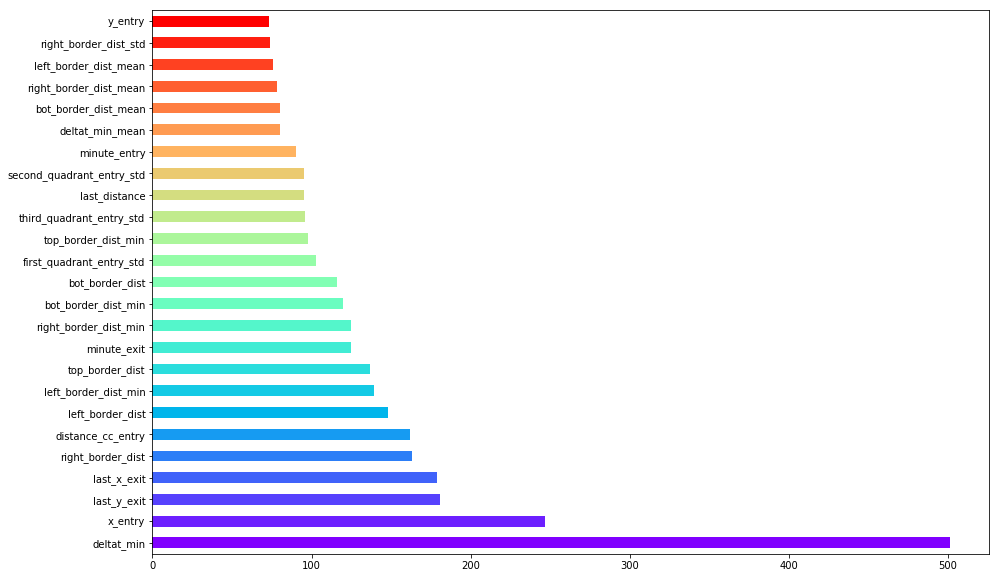

In [70]:
f, ax = plt.subplots(figsize=(15, 10))

feat_importances_gb = pd.Series(pipeline.steps[0][1].feature_importances_, index=data_train[features].columns)
feat_importances_gb.nlargest(25).plot(kind='barh', color=cm.rainbow(np.linspace(0, 1, 25)))

## Features Set 2

In [71]:
features += ['last_y_entry', 'last_x_entry', 'trajectory_sum', 'distance_blind_mean', 
            'last_distance_blind', 'last_time_delta_blind']

In [72]:
pipeline = make_pipeline(LGBMClassifier(n_estimators=150, seed=20))

pipeline.fit(dt_train[features], dt_train[target])
predicted = pipeline.predict(dt_test[features])

f1_score(dt_test[target], predicted)

0.88375379831814

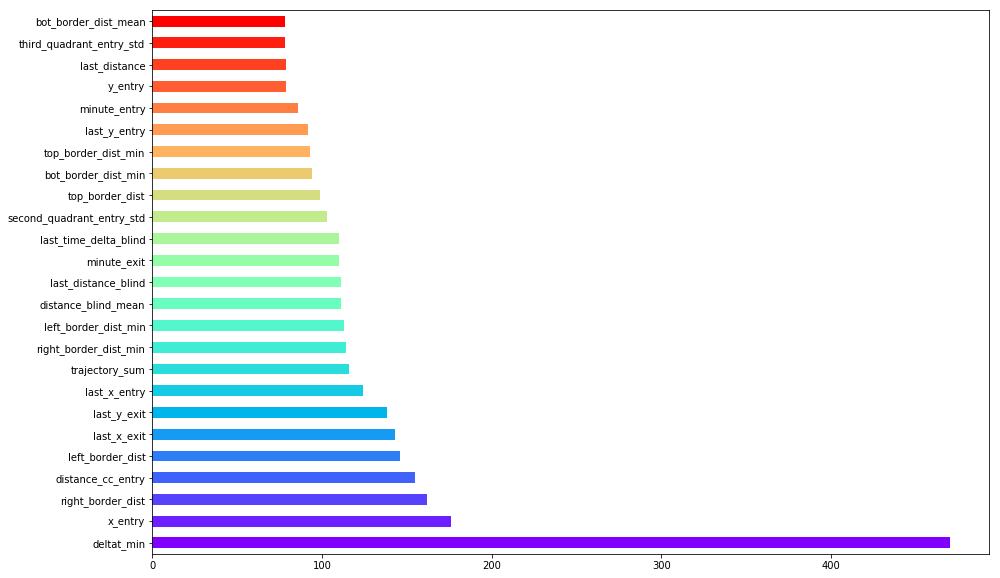

In [73]:
f, ax = plt.subplots(figsize=(15, 10))

feat_importances_gb = pd.Series(pipeline.steps[0][1].feature_importances_, index=data_train[features].columns)
feat_importances_gb.nlargest(25).plot(kind='barh', color=cm.rainbow(np.linspace(0, 1, 25)))

## Features Set 3

In [76]:
list(set(data_train.columns) - set(features))

features += ['distance_cc_entry_mean',
     'last_diff_cc_exit_entry',
     'distance_cc_exit_mean',
     'diff_cc_exit_entry_mean',
     'last_distance_cc_entry',
     'x_diff_entry',
     'last_distance_cc_exit',
     'trajectory_number',
     'last_is_inside_city_exit',
     'x_delta_blind',
     'y_diff_entry',
     'is_inside_city_exit_mean']

pipeline.fit(dt_train[features], dt_train[target])
predicted = pipeline.predict(dt_test[features])

f1_score(dt_test[target], predicted)

0.885164757460048

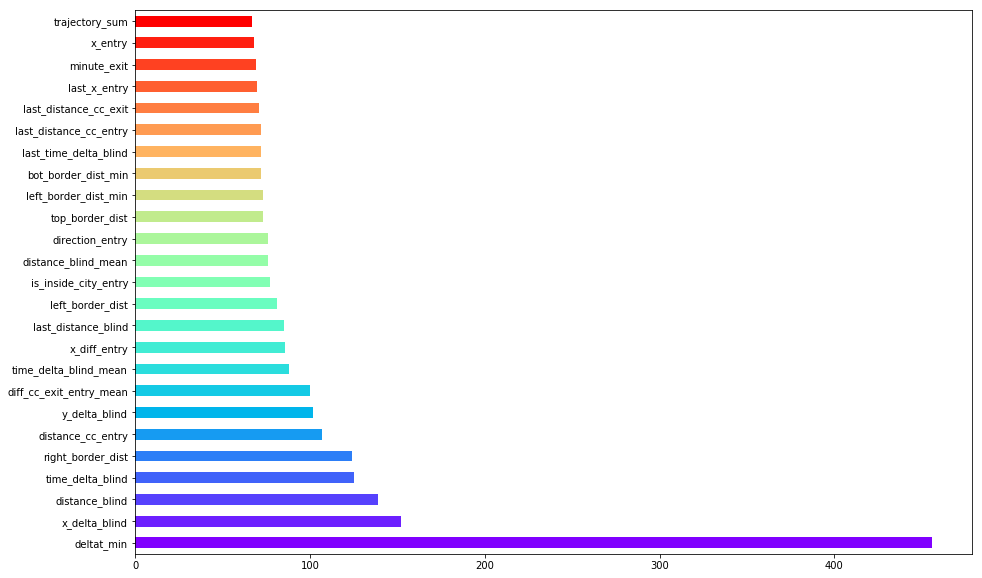

In [77]:
f, ax = plt.subplots(figsize=(15, 10))

feat_importances_gb = pd.Series(pipeline.steps[0][1].feature_importances_, index=data_train[features].columns)
feat_importances_gb.nlargest(25).plot(kind='barh', color=cm.rainbow(np.linspace(0, 1, 25)))

## Feature Set 4

In [74]:
features += ['time_delta_blind_mean',
         'direction_entry_mean',
         'last_direction_exit',
         'last_diff_cc_exit_entry_direction',
         'time_delta_blind',
         'y_delta_blind',
         'direction_entry',
         'last_direction_entry',
         'last_diff_cc_exit_exit_direction',
         'direction_exit_mean',
         'diff_cc_exit_exit_direction_mean',
         'distance_blind']

pipeline.fit(dt_train[features], dt_train[target])
predicted = pipeline.predict(dt_test[features])

f1_score(dt_test[target], predicted)

0.8825612693016008

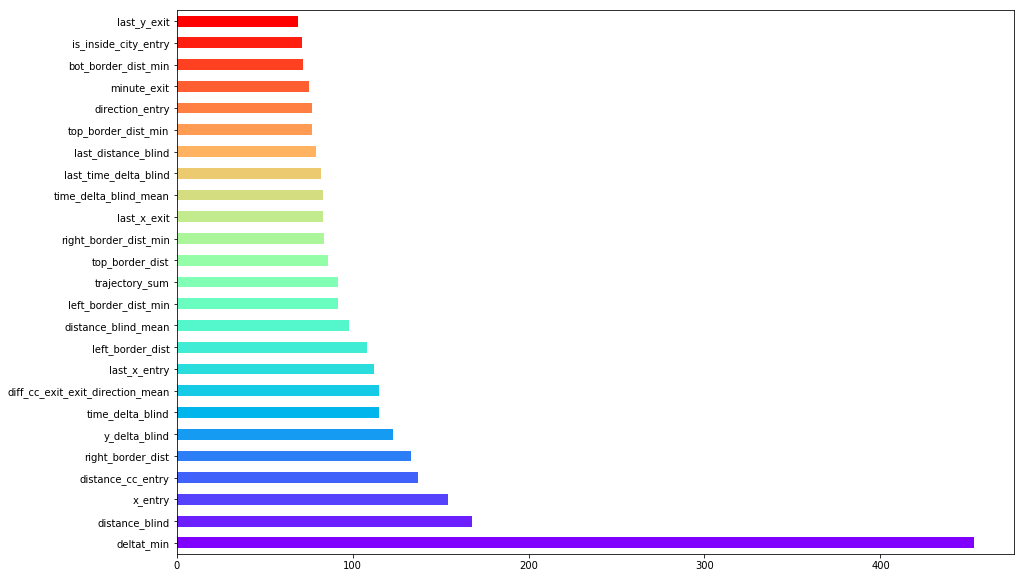

In [75]:
f, ax = plt.subplots(figsize=(15, 10))

feat_importances_gb = pd.Series(pipeline.steps[0][1].feature_importances_, index=data_train[features].columns)
feat_importances_gb.nlargest(25).plot(kind='barh', color=cm.rainbow(np.linspace(0, 1, 25)))

## Feature Set 5

In [78]:
list(set(data_train.columns) - set(features))

features += [
         'direction_entry_min',
         'direction_exit_sum',
         'distance_blind_sum',
         'diff_cc_exit_entry_direction_min',
         'time_delta_blind_std',
         'time_delta_blind_min',
         'diff_cc_exit_exit_direction_max',
         'minkowski_distance_mean',
         'last_minkowski_distance',
         'distance_cc_exit_std',
         'diff_cc_exit_entry_sum',
         'distance_cc_exit_sum',
         'direction_exit_min',
         'minkowski_distance_max',
         'direction_exit_std',
         'time_delta_blind_max',
         'diff_cc_exit_entry_min',
         'distance_cc_entry_std',
         'distance_cc_exit_min',
         'direction_entry_std',
         'direction_exit_max',
         'diff_cc_exit_entry_direction_max',
         'is_inside_city_exit_min',
         'distance_cc_entry_max',
         'diff_cc_exit_exit_direction_std',
         'is_inside_city_exit_max',
         'direction_entry_sum',
         'minkowski_distance_std',
         'diff_cc_exit_entry_direction_mean',
         'distance_cc_exit_max',
         'distance_blind_min',
         'is_inside_city_exit_sum',
         'minkowski_distance_sum',
         'diff_cc_exit_exit_direction_min',
         'diff_cc_exit_exit_direction_sum',
         'direction_entry_max',
         'minkowski_distance_min',
         'distance_cc_entry_sum',
         'diff_cc_exit_entry_direction_sum',
         'diff_cc_exit_entry_max',
         'is_inside_city_exit_std',
         'distance_blind_max',
         'distance_cc_entry_min',
         'time_delta_blind_sum',
         'diff_cc_exit_entry_direction_std',
         'distance_blind_std',
         'diff_cc_exit_entry_std']

pipeline.fit(dt_train[features], dt_train[target])
predicted = pipeline.predict(dt_test[features])

f1_score(dt_test[target], predicted)

0.8860795253902111

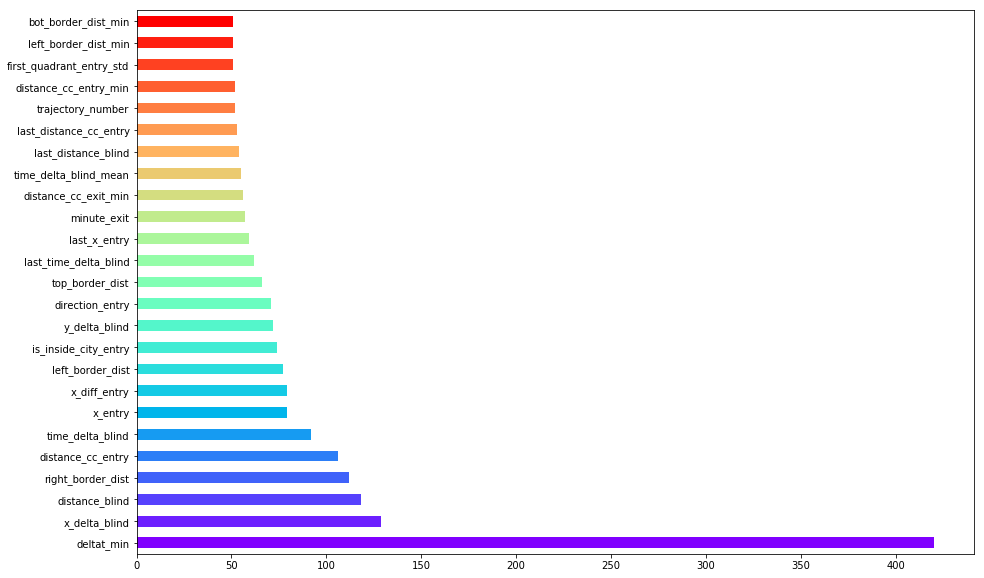

In [79]:
f, ax = plt.subplots(figsize=(15, 10))

feat_importances_gb = pd.Series(pipeline.steps[0][1].feature_importances_, index=data_train[features].columns)
feat_importances_gb.nlargest(25).plot(kind='barh', color=cm.rainbow(np.linspace(0, 1, 25)))

## Feature Set 6

In [82]:
features += ['vuniform_mean', 'vuniform_max', 'vuniform_std', 'vuniform_min', 'vuniform_sum']

pipeline.fit(dt_train[features], dt_train[target])
predicted = pipeline.predict(dt_test[features])

f1_score(dt_test[target], predicted)

0.8862673071489121

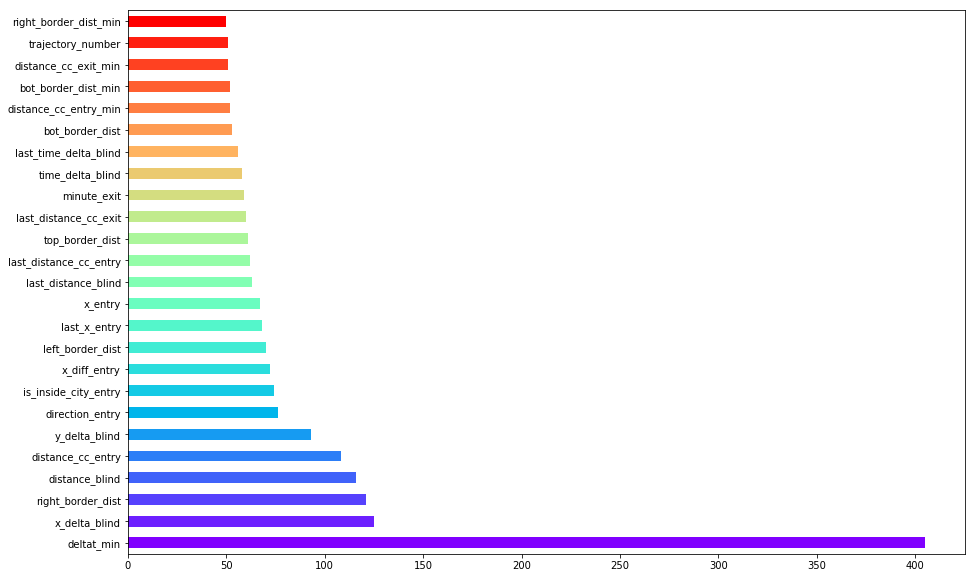

In [83]:
f, ax = plt.subplots(figsize=(15, 10))

feat_importances_gb = pd.Series(pipeline.steps[0][1].feature_importances_, index=data_train[features].columns)
feat_importances_gb.nlargest(25).plot(kind='barh', color=cm.rainbow(np.linspace(0, 1, 25)))

## Submission

In [84]:
data_test = test[test.x_exit.isnull()].copy()
data_test = data_test.fillna(value=0.0)

In [85]:
data_test.shape

(33515, 185)

In [86]:
pipeline.fit(data_train[features], data_train[target])
yhat = pipeline.predict(data_test[features])

In [87]:
pd.Series(yhat).value_counts()

0    25126
1     8389
dtype: int64

In [88]:
submission = pd.DataFrame(list(zip(data_test.trajectory_id, yhat)), columns=['id', 'target'])

In [89]:
submission.to_csv('../data/submission27.csv', index=False)

## Saving data

In [108]:
data.to_csv('../data/preprocessed/data_preprocessed.csv', sep=',', index=False)

In [63]:
data.to_hdf('../data/preprocessed/data_preprocessed.hdf', key='data', mode='w')